<a href="https://colab.research.google.com/github/baeksumin/k-project/blob/main/data_preprocessing/optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GDC(Golden Dead Cross)

In [1]:
!pip install backtrader

     |████████████████████████████████| 410 kB 5.1 MB/s 


In [2]:
pip install finance-datareader

In [3]:
pip install backtesting

     |████████████████████████████████| 174 kB 5.0 MB/s 
  Created wheel for backtesting: filename=Backtesting-0.3.2-py3-none-any.whl size=173671 sha256=28c641743892e97c1b4c5caa061a0890fde294bbe0b3d1a00b7a3c3e6bc2bc75
  Stored in directory: /root/.cache/pip/wheels/22/0e/30/e458272563bdbea1905391b5bb5702e2001a769544d9cb2df3
Successfully built backtesting


In [4]:
pip install deap

     |████████████████████████████████| 160 kB 5.0 MB/s 


In [5]:
import json
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, date, timedelta
from google.colab import drive
import backtrader as bt
from IPython.display import display, Image
import backtrader.feeds as btfeeds
from backtesting import Strategy
from backtesting import Backtest
from deap import base, creator, tools, algorithms

/usr/local/lib/python3.7/dist-packages/backtesting/_plotting.py:47: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


In [7]:
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/[Shared]K-Project/data/'

Mounted at /content/drive


In [8]:
# 저장된 삼성전자(KR7005930003) 데이터 가져오기

with open(data_path + 'initial_data1.json',"r") as json_file:
    json_data = json.load(json_file) 

df = pd.read_json(json_data['KR7005930003'], orient ='index') 
samsung = df.transpose()
samsung

,TRD_DD,ISU_CD,ISU_NM,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,EPS,PER,BPS,PBR,DPS,DVD_YLD,ACC_TRDVOL
0,2021/11/23,005930,삼성전자,"75,300","76,000","76,000","74,500","449,524,626,015,000","3,841",19.60,"39,406",1.91,"2,994",3.98,None
1,2021/11/22,005930,삼성전자,"74,900","73,300","75,200","73,000","447,136,712,995,000","3,841",19.50,"39,406",1.90,"2,994",4.00,None
2,2021/11/19,005930,삼성전자,"71,200","70,400","71,400","70,100","425,048,517,560,000","3,841",18.54,"39,406",1.81,"2,994",4.21,None
3,2021/11/18,005930,삼성전자,"70,200","70,700","71,000","70,200","419,078,735,010,000","3,841",18.28,"39,406",1.78,"2,994",4.26,None
4,2021/11/17,005930,삼성전자,"70,700","71,300","71,600","70,600","422,063,626,285,000","3,841",18.41,"39,406",1.79,"2,994",4.23,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6723,1995/05/08,005930,삼성전자,"121,000","122,000","122,000","120,500","6,578,606,045,000",-,-,-,-,-,-,"91,810"
6724,1995/05/06,005930,삼성전자,"122,000","122,000","123,500","122,000","6,632,974,690,000",-,-,-,-,-,-,"47,440"
6725,1995/05/04,005930,삼성전자,"122,500","124,000","124,500","122,000","6,660,159,012,500",-,-,-,-,-,-,"175,590"
6726,1995/05/03,005930,삼성전자,"123,500","119,500","126,500","119,500","6,714,527,657,500",-,-,-,-,-,-,"382,980"


In [9]:
#시간순 재정렬
samsung = samsung.sort_values(by=['TRD_DD'])
samsung.reset_index(drop=True,inplace=True)
samsung['TRD_DD']=pd.to_datetime(samsung['TRD_DD']) #datetime변환

In [10]:
samsung

,TRD_DD,ISU_CD,ISU_NM,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,EPS,PER,BPS,PBR,DPS,DVD_YLD,ACC_TRDVOL
0,1995-05-02,005930,삼성전자,"119,500","121,000","121,000","118,500","6,497,053,077,500",-,-,-,-,-,-,"139,560"
1,1995-05-03,005930,삼성전자,"123,500","119,500","126,500","119,500","6,714,527,657,500",-,-,-,-,-,-,"382,980"
2,1995-05-04,005930,삼성전자,"122,500","124,000","124,500","122,000","6,660,159,012,500",-,-,-,-,-,-,"175,590"
3,1995-05-06,005930,삼성전자,"122,000","122,000","123,500","122,000","6,632,974,690,000",-,-,-,-,-,-,"47,440"
4,1995-05-08,005930,삼성전자,"121,000","122,000","122,000","120,500","6,578,606,045,000",-,-,-,-,-,-,"91,810"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6723,2021-11-17,005930,삼성전자,"70,700","71,300","71,600","70,600","422,063,626,285,000","3,841",18.41,"39,406",1.79,"2,994",4.23,None
6724,2021-11-18,005930,삼성전자,"70,200","70,700","71,000","70,200","419,078,735,010,000","3,841",18.28,"39,406",1.78,"2,994",4.26,None
6725,2021-11-19,005930,삼성전자,"71,200","70,400","71,400","70,100","425,048,517,560,000","3,841",18.54,"39,406",1.81,"2,994",4.21,None
6726,2021-11-22,005930,삼성전자,"74,900","73,300","75,200","73,000","447,136,712,995,000","3,841",19.50,"39,406",1.90,"2,994",4.00,None


In [11]:
#인풋 데이터 모양 맞춰주기(backtest에 들어갈 데이터 모양)
samsung_bt = samsung[['TRD_DD','TDD_OPNPRC','TDD_HGPRC','TDD_LWPRC','TDD_CLSPRC', 'ACC_TRDVOL']]
samsung_bt['TRD_DD'] = pd.to_datetime(samsung_bt['TRD_DD'])
samsung_bt.rename(columns={'TRD_DD':'Date', 'TDD_OPNPRC':'Open', 'TDD_HGPRC':'High','TDD_LWPRC':'Low','TDD_CLSPRC':'Close', 'ACC_TRDVOL':'Volume'}, inplace=True)
samsung_bt.set_index('Date',drop=True,inplace=True)
samsung_bt

#데이터프레임 콤마(,) 제거 그리고 타입 소수로 변환
samsung_bt['Open'] = samsung_bt['Open'].str.replace(',','').astype('float')
samsung_bt['High'] = samsung_bt['High'].str.replace(',','').astype('float')
samsung_bt['Low'] = samsung_bt['Low'].str.replace(',','').astype('float')
samsung_bt['Close'] = samsung_bt['Close'].str.replace(',','').astype('float')
samsung_bt['Volume'] = samsung_bt['Volume'].str.replace(',','').astype('float')
samsung_bt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

,Open,High,Low,Close,Volume
Date,,,,,
1995-05-02,121000.0,121000.0,118500.0,119500.0,139560.0
1995-05-03,119500.0,126500.0,119500.0,123500.0,382980.0
1995-05-04,124000.0,124500.0,122000.0,122500.0,175590.0
1995-05-06,122000.0,123500.0,122000.0,122000.0,47440.0
1995-05-08,122000.0,122000.0,120500.0,121000.0,91810.0
...,...,...,...,...,...
2021-11-17,71300.0,71600.0,70600.0,70700.0,NaN
2021-11-18,70700.0,71000.0,70200.0,70200.0,NaN
2021-11-19,70400.0,71400.0,70100.0,71200.0,NaN


In [12]:
df = samsung_bt.copy()
df

,Open,High,Low,Close,Volume
Date,,,,,
1995-05-02,121000.0,121000.0,118500.0,119500.0,139560.0
1995-05-03,119500.0,126500.0,119500.0,123500.0,382980.0
1995-05-04,124000.0,124500.0,122000.0,122500.0,175590.0
1995-05-06,122000.0,123500.0,122000.0,122000.0,47440.0
1995-05-08,122000.0,122000.0,120500.0,121000.0,91810.0
...,...,...,...,...,...
2021-11-17,71300.0,71600.0,70600.0,70700.0,NaN
2021-11-18,70700.0,71000.0,70200.0,70200.0,NaN
2021-11-19,70400.0,71400.0,70100.0,71200.0,NaN


# backtest

In [13]:
class SmaCross1(bt.Strategy):
  params = dict(
        pfast=50, # period for the fast moving average
        pslow=200 # period for the slow moving average 
        ) 
  
  def __init__(self):
    sma1 = bt.ind.SMA(period = self.p.pfast) # fast moving average 
    sma2 = bt.ind.SMA(period = self.p.pslow) # slow moving average 
    self.crossover = bt.ind.CrossOver(sma1, sma2) # crossover signal 

  def next(self): 
    if not self.position: # not in the market 
        if self.crossover > 0: # if fast crosses slow to the upside 
            close = self.data.close[0] # 종가 값 
                
            size = int(self.broker.getcash() / close) # 최대 구매 가능 개수 
            self.buy(size=size) # 매수 size = 구매 개수 설정 
    elif self.crossover < 0: # in the market & cross to the downside 
            self.close() # 매도



In [14]:
# 세레브로 (벡트레이더 엔진) 설정

# 세레브로 가져오기
cerebro = bt.Cerebro()

# 데이터 가져오기
data = bt.feeds.PandasData(dataname=df,name="SAMSUNG")


# 데이터 추가하기
cerebro.adddata(data)

# 전략 추가하기
cerebro.addstrategy(SmaCross1)

# 브로커 설정
cerebro.broker.setcash (1000000)

# 매매 단위 설정
cerebro.addsizer(bt.sizers.SizerFix, stake = 30) #한번에 30주 설정.

최종금액 :  1369350.0 원
수익률 :  36.935 %




<IPython.core.display.Javascript object>

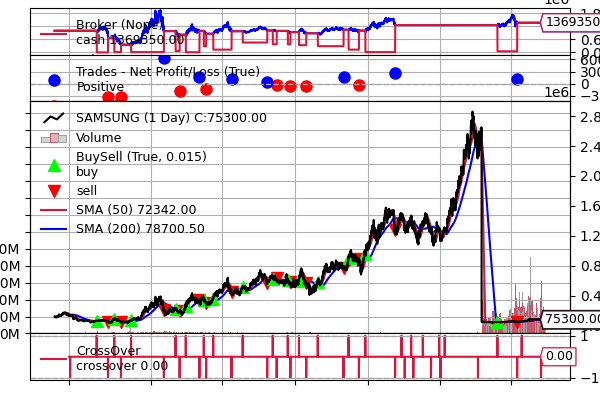

In [15]:
# 3. 세레브로 실행하기

# 초기 투자금 가져오기
init_cash = cerebro.broker.getvalue()

# 세레브로 실행하기
cerebro.run()

# 최종 금액 가져오기
final_cash = cerebro.broker.getvalue()

print("최종금액 : ", final_cash, "원")
print("수익률 : ", float(final_cash - init_cash)/float(init_cash) * 100., "%")
print("\n")

# 차트 출력하기
cerebro.plot()[0][0].savefig('plot.png', dpi=100)
display(Image(filename='plot.png'))

# GA

In [16]:
import random
import seaborn as sns
from tqdm import trange
import time

In [50]:
random.seed(3)

PARAM_NAMES = ["pfast", "pslow"]

NGEN = 5   # 알고리즘 5번 반복.
NPOP = 100  #인구 초기
CXPB = 0.5   #교차 전략 
MUTPB = 0.3   #돌연변이 전략.


#최소fintness 설정.(fitness값이 작을수록 좋도록 설정.)
#creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
#creator.create('Individual', list, fitness=creator.FitnessMin)

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

def evaluate(individual, plot=False, log=False):

  strategy_params = {k: v for k, v in zip(PARAM_NAMES, individual)}

  cerebro = bt.Cerebro(stdstats=False)
  cerebro.adddata(data)

  initial_capital = 1000000
  cerebro.broker.setcash(initial_capital)

  cerebro.addstrategy(SmaCross1, **strategy_params)

  cerebro.addanalyzer(bt.analyzers.DrawDown)

  cerebro.broker.setcommission(commission=0.0025, margin=False)   #수수료 설정.

  strats = cerebro.run()

  profit = cerebro.broker.getvalue() - initial_capital

  max_dd = strats[0].analyzers.drawdown.get_analysis()["max"]["moneydown"] # max.moneydown - max drawdown value in monetary units
  fitness = profit / (max_dd if max_dd > 0 else 1)

  if log:
    print(f"Starting Portfolio Value: {initial_capital:,.2f}")
    print(f"Final Portfolio Value:    {cerebro.broker.getvalue():,.2f}")
    print(f"Total Profit:             {profit:,.2f}")
    print(f"Maximum Drawdown:         {max_dd:,.2f}")
    print(f"Profit / Max DD:          {fitness}")

  if plot:
    cerebro.plot()

  return [fitness]

toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(NPOP), NPOP)

# crossover strategy
toolbox.register("mate", tools.cxUniform, indpb=CXPB)
# mutation strategy
toolbox.register("mutate", tools.mutUniformInt, low=1, up=151, indpb=0.2)
# selection strategy
toolbox.register("select", tools.selTournament, tournsize=3)
# fitness function
toolbox.register("evaluate", evaluate)


# definition of an individual & a population
toolbox.register("attr_sma1", random.randint, 1, 100)
toolbox.register("attr_sma2", random.randint, 151, 251)  #기간 1~100 범위 설정.
toolbox.register(
    "individual",
    tools.initCycle,
    creator.Individual,
    (
        toolbox.attr_sma1,
        toolbox.attr_sma2,

    ),
)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

mean = np.ndarray(NGEN)
best = np.ndarray(NGEN)
hall_of_fame = tools.HallOfFame(maxsize=3)

t = time.perf_counter()
pop = toolbox.population(n=NPOP)
for g in trange(NGEN):
    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    # Apply mutation on the offspring
    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # The population is entirely replaced by the offspring
    pop[:] = offspring
    hall_of_fame.update(pop)
    print(
        "HALL OF FAME:\n"
        + "\n".join(
            [
                f"    {_}: {ind}, Fitness: {ind.fitness.values[0]}"
                for _, ind in enumerate(hall_of_fame)
            ]
        )
    )

    fitnesses = [
        ind.fitness.values[0] for ind in pop if not np.isinf(ind.fitness.values[0])
    ]
    mean[g] = np.mean(fitnesses)
    best[g] = np.max(fitnesses)

end_t = time.perf_counter()
print(f"Time Elapsed: {end_t - t:,.2f}")

fig, ax = plt.subplots(sharex=True, figsize=(16, 9))

sns.lineplot(x=range(NGEN), y=mean, ax=ax, label="Average Fitness Score")
sns.lineplot(x=range(NGEN), y=best, ax=ax, label="Best Fitness Score")
ax.set_title("Fitness Score")
ax.set_xticks(range(NGEN))
ax.set_xlabel("Iteration")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
 20%|██        | 1/5 [04:08<16:33, 248.39s/it]

HALL OF FAME:
    0: [28, 129], Fitness: 2.9224001954215524
    1: [44, 238], Fitness: 2.6157614461194862
    2: [52, 156], Fitness: 2.286056377863675


 40%|████      | 2/5 [06:45<09:44, 194.77s/it]

HALL OF FAME:
    0: [44, 129], Fitness: 3.3223409564227664
    1: [35, 120], Fitness: 3.2742751092246887
    2: [50, 123], Fitness: 3.2472937763822753


 60%|██████    | 3/5 [09:20<05:53, 176.74s/it]

HALL OF FAME:
    0: [26, 129], Fitness: 4.482500069825293
    1: [35, 129], Fitness: 3.52497860318936
    2: [44, 129], Fitness: 3.3223409564227664


 80%|████████  | 4/5 [12:17<02:56, 176.71s/it]

HALL OF FAME:
    0: [26, 129], Fitness: 4.482500069825293
    1: [20, 129], Fitness: 3.8545397662732714
    2: [35, 129], Fitness: 3.52497860318936


100%|██████████| 5/5 [14:50<00:00, 178.08s/it]

HALL OF FAME:
    0: [26, 129], Fitness: 4.482500069825293
    1: [20, 129], Fitness: 3.8545397662732714
    2: [24, 156], Fitness: 3.726386378609074
Time Elapsed: 890.41


<IPython.core.display.Javascript object>

In [51]:
OPTIMISED_STRATEGY_PARAMS = {
    k: v for k, v in zip(PARAM_NAMES, hall_of_fame[0])}
print(OPTIMISED_STRATEGY_PARAMS)

{'pfast': 26, 'pslow': 129}


최종금액 :  24554600.0 원
수익률 :  2355.46 %




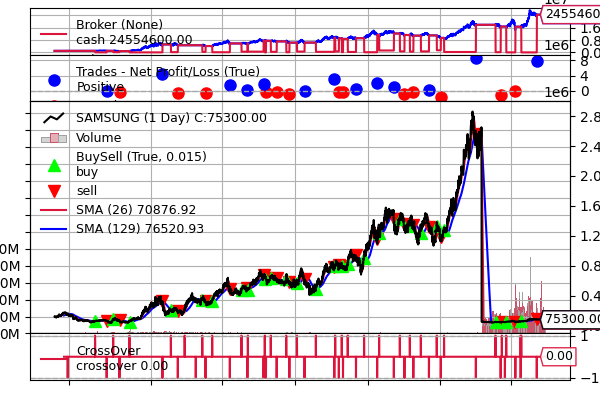

In [52]:
# gdc

class SmaCross1(bt.Strategy):
  params = dict(
        pfast=26, # period for the fast moving average
        pslow=129 # period for the slow moving average 
        ) 
  
  def __init__(self):
    sma1 = bt.ind.SMA(period = self.p.pfast) # fast moving average 
    sma2 = bt.ind.SMA(period = self.p.pslow) # slow moving average 
    self.crossover = bt.ind.CrossOver(sma1, sma2) # crossover signal 

  def next(self): 
    if not self.position: # not in the market 
        if self.crossover > 0: # if fast crosses slow to the upside 
            close = self.data.close[0] # 종가 값 
                
            size = int(self.broker.getcash() / close) # 최대 구매 가능 개수 
            self.buy(size=size) # 매수 size = 구매 개수 설정 
    elif self.crossover < 0: # in the market & cross to the downside 
            self.close() # 매도




# 세레브로 (벡트레이더 엔진) 설정

#세레브로 가져오기
cerebro = bt.Cerebro()

#데이터 가져오기
data = bt.feeds.PandasData(dataname=df,name="SAMSUNG",openinterest=None)

#데이터 추가하기
cerebro.adddata(data)

#전략 추가하기
cerebro.addstrategy(SmaCross1)

#브로커 설정
cerebro.broker.setcash (1000000)

#매매 단위 설정
cerebro.addsizer(bt.sizers.SizerFix, stake = 30) #한번에 30주 설정.

# 3. 세레브로 실행하기

# 초기 투자금 가져오기
init_cash = cerebro.broker.getvalue()

# 세레브로 실행하기
cerebro.run()

# 최종 금액 가져오기
final_cash = cerebro.broker.getvalue()


print("최종금액 : ", final_cash, "원")
print("수익률 : ", float(final_cash - init_cash)/float(init_cash) * 100., "%")
print("\n")

# 차트 출력하기
cerebro.plot()[0][0].savefig('plot.png', dpi=100)
display(Image(filename='plot.png'))